# Cluster simulation

In [1]:
import random
import matplotlib.pyplot as plt

## Classes

### Job class

In [2]:
class Job():
    '''
    This class aims to represent jobs that are to be assigned to nodes
    The basic characteristics of nodes jobs are CPU request,
    memory request and file size to send to the master. These numbers represent the max,
    resoruces the job will use from the node
    '''
    
    def __init__(self, job_id, cpu_request, memory_request, file_size):
        self.job_id = job_id
        self.cpu_request = cpu_request
        self.memory_request = memory_request
        self.file_size = file_size
    
    def set_cpu_request(self, cpu_request):
        ''' This method sets the CPU request of the job'''
        self.cpu_request = cpu_request
        
    def set_memory_request(self, memory_request):
        ''' This method sets the memory request of the job'''
        self.memory_request = memory_request
        
    def set_file_size(self, file_size):
        ''' 
        This method sets the file size of the job
        For now the file_size is represented as standard integer units.
        More info in bw method of class Node()
        '''
        self.file_size = file_size
    
    def get_job_id(self):
        '''This method returns the id of the job'''
        return self.job_id
        
    def get_cpu_request(self):
        ''' This method returns CPU request of the job'''
        return self.cpu_request
    
    def get_memory_request(self):
        ''' This method returns the memory request'''
        return self.memory_request
    
    def get_file_size(self):
        ''' This method returns the file size'''
        return self.file_size

### Node class

In [3]:
class Node():
    '''
    This class aims to represente computing nodes of a cluster
    The basic properties of the nodes are CPU, memory and bandwidth (BW)
    BW is considered the capacity of data transmision between the node and an hypothetic node where data is sent
    '''
    
    def __init__(self, node_id, cpu_capacity, memory_capacity, bw):
        self.node_id = node_id
        self.cpu_capacity = cpu_capacity
        self.memory_capacity = memory_capacity
        self.bw = bw
        self.cpu_available = cpu_capacity
        self.memory_available = memory_capacity
        self.cpu_used = 0
        self.memory_used = 0
        self.jobs = []
        
    def set_cpu_capacity(self, cpu_capacity):
        '''
        This method sets the total CPU capacity of the node
        The CPU units are in milicores: 1000m = 1core
        Whenever this method is call the available CPU gets to 100%. The jobs are released
        '''
        if cpu_capacity - self.cpu_used < 0:
            print('CPU resources cannot be reduced')
        else:
            self.cpu_capacity = cpu_capacity
            self.update_available_resources()
    
    def set_memory_capacity(self, memory_capacity):
        '''
        This method sets the total memory capacity of the node
        The memory units are MB: 1GB = 1000MB = 1000000KB
        Whenever this method is call the available CPU gets to 100%. The jobs are released
        '''
        if memory_capacity - self.memory_used < 0:
            print('Memory resources cannot be reduced')
        else:
            self.memory_capacity = memory_capacity
            self.update_available_resources()
        
    def set_bw(self, bw):
        '''
        This method sets the total bw capacity of the link b
        For now the bandwidth is represented as the number of file_size units
        the node is capable to consume in one time step
        '''
        self.bw = bw
        
    def get_node_id(self):
        return self.node_id
        
    def get_cpu_capacity(self):
        '''This method returns the cpu capacity of the node'''
        return self.cpu_capacity
    
    def get_memory_capacity(self):
        '''This method returns the memory capcity of the node'''
        return self.memory_capacity
    
    def get_bw(self):
        '''This method returns the bw'''
        return self.bw
    
    def get_cpu_used(self):
        '''This method returns the used CPU'''
        return self.cpu_used
        
    def get_memory_used(self):
        '''This method returns the used memory'''
        return self.memory_used
    
    def get_cpu_available(self):
        '''This method returns the available CPU'''
        return self.cpu_available
    
    def get_memory_available(self):
        '''This method returns the available memory'''
        return self.memory_available
    
    def get_jobs(self):
        '''
        This method returns a list of dicts containing the jobs allocated in the nodes
        and their remaining time of execution in the node
        '''
        return self.jobs
    
    def update_available_resources(self):
        '''This method updates the available resources'''
        self.cpu_available = self.cpu_capacity - self.cpu_used
        self.memory_available = self.memory_capacity - self.memory_used
        
    def consume_resources(self, job):
        '''
        This method decreases the available cpu and memory
        based on the appended job CPU and memory requests.
        '''
        self.cpu_used += job.get_cpu_request()
        self.memory_used += job.get_memory_request()
        self.update_available_resources()
        
    def release_resources(self, job):
        ''' 
        This method calculates and returns the file transfer time
        given the file size and the bw of the node
        '''
        self.cpu_used -= job.get_cpu_request()
        self.memory_used -= job.get_memory_request()
        self.update_available_resources()
        
    def transfer_duration(self, job):
        ''' 
        This method calculates and returns the file transfer time
        given the file size and the bw of the node
        '''
        total_transfer_duration = job.get_file_size() / self.bw
        return total_transfer_duration
    
    def check_resources(self, job):
        '''
        This method returns a False if the node has not enough available resources to allocate the job.
        Returns True otherwise
        '''
        cpu_resources = job.get_cpu_request() > self.get_cpu_available()
        memory_resources = job.get_memory_request() > self.get_memory_available()
        if cpu_resources or memory_resources:
            return False
        else:
            return True
    
    def check_jobs(self):
        '''
        Returns True if the node contain running jobs
        Returns False if the node does not contain running jobs
        '''
        flag = True
        if not self.jobs:
            flag = False
            
        return flag  
        
    def decrease_job_time(self):
        '''
        This method decreases the duration of all the jobs allocated in that node by one
        If the remaining time is 0, the job is terminated from the node
        '''
        jobs_copy = self.jobs[:]
        for job in jobs_copy:
            if job['time'] == 1:
                self.terminate_job(job)
        for job in self.jobs:
            job['time'] -= 1      
            
    def append_job(self, job):
        '''
        This method appends the job passed as an argument to the node.
        The available resources in the node are updated.
        The transfer time of the file attached to job is calculated and returned
        '''
        if self.check_resources(job):
            total_transfer_duration = self.transfer_duration(job)
            self.jobs.append({
                'job': job,
                'time': total_transfer_duration
            })
            self.consume_resources(job)   
            return total_transfer_duration
        else:
            print('The job cannot be allocated. There is not enough available resoruces in the node.')
    
    def terminate_job(self, job):
        '''
        This method releases the specified job running in the node
        The available resources in the node are updated
        '''
        self.jobs.remove(job)
        self.release_resources(job['job'])

## Functions

In [4]:
def main_simulation(n_nodes, nodes_cpu, nodes_memory, nodes_bw, jobs_list, display='0'):
    nodes = [Node(i, nodes_cpu[i], nodes_memory[i], nodes_bw[i]) for i in range(n_nodes)]
    
    n_new_jobs = []
    n_jobs_nodes = [[] for i in range(len(nodes))]
    cpu_nodes_list = [[] for i in range(len(nodes))]
    memory_nodes_list = [[] for i in range(len(nodes))]
    job_duration_list = []
    iteration = 0

    # Run while jobs in list of pending jobs or while any nodehas jobs running
    while jobs_list or jobs_running(nodes):
        # Decrease exec time by 1 of all the jobs allocated in the nodes
        for node in nodes:
            node.decrease_job_time()
        
        # Generate a number of jobs to allocate
        n_jobs_iteration = number_of_jobs(jobs_list, 2, 4)
        if jobs_list:
            # Allocate each job in a random node in the cluster
            for i in range(n_jobs_iteration):
                node = random.choice(nodes)
                job_duration = node.append_job(jobs_list.pop())
                job_duration_list.append(job_duration)
        
        # Store data for visualization
        n_new_jobs.append(n_jobs_iteration)
        for i, node in enumerate(nodes):
            n_jobs_nodes[i].append(len(node.get_jobs())) 
            cpu_nodes_list[i].append(node.get_cpu_used())
            memory_nodes_list[i].append(node.get_memory_used())
            
        if display == 1 or display == 2:
            # Display real time status of nodes
            display_node_status(nodes)
            
        iteration += 1
    
    if display == 0 or display == 1:
        # Visualize data from the simulation
        display_avg_job_duration(job_duration_list)
        display_njobs_ts(n_new_jobs, n_jobs_nodes)
        display_cpu_usage(nodes, cpu_nodes_list)
        display_memory_usage(nodes, memory_nodes_list)

In [5]:
def number_of_jobs(jobs_list, n_min, n_max):
    '''
    This function generates a number between n_min and n_max
    for the number of jobs to be allocated at each time-step.
    When the number of remaining jobs in the list is less than the generated number,
    the number of jobs is the remaining jobs to be allocated
    '''
    n_jobs_iteration = random.randint(n_min, n_max)
    if n_jobs_iteration > len(jobs_list):
        n_jobs_iteration = len(jobs_list)
    elif not jobs_list:
        n_jobs_iteration = 0
    return n_jobs_iteration

In [6]:
def display_node_status(nodes):
    '''
    This function displays the status of each node at each time step.
    CPU usage, memopry usage and allocated jobs.
    Requires as an input a list of nodes
    '''
    status = '\n Iteration ' + str(iteration)
    for node in nodes:
        status += '\n \t Status of Node ' + str(node.get_node_id()) + ':'
        status += '\n \t \t Bw: ' + str(node.get_bw())
        status += '\n \t \t CPU: ' + str(node.get_cpu_used()) + '/' + str(node.get_cpu_capacity()) + ' c'
        status += '\n \t \t Memory: ' + str(node.get_memory_used()) + '/' + str(node.get_memory_capacity()) + ' MB'
        status += '\n \t \t Jobs allocated:'
        for job in node.get_jobs():
            status += '\n \n \t \t \t Job: ' + str(job['job'].get_job_id())
            status += '\n \t \t \t CPU req: ' + str(job['job'].get_cpu_request()) + ' c'
            status += '\n \t \t \t Memory req: ' + str(job['job'].get_memory_request()) + ' MB'
            status += '\n \t \t \t Time remaining: ' + str(job['time']) + 's'
        print(status)
        status = ''

In [7]:
def display_njobs_ts(n_new_jobs, n_jobs_nodes):
    '''
    This function plots the new number of jobs allocated at each time step and 
    the number of jobs in each node in each timestep as a time series
    '''
    max_value = 0
    max_value = [max(node) for node in n_jobs_nodes if max_value < max(node)][0] + 1
    plt.figure(figsize=(7,10))
    plt.subplot(len(n_jobs_nodes) + 1, 1, 1)
    plt.ylim(top=max_value)
    plt.title('Number of new jobs per iteration')
    plt.plot(n_new_jobs)
    
    for i, node in enumerate(n_jobs_nodes):
        plt.subplot(len(n_jobs_nodes)+1, 1, i+2)
        plt.ylim(top=max_value)
        plt.title('Number of jobs in Node ' + str(i+1))
        plt.plot(node)

    plt.show()

In [8]:
def display_cpu_usage(nodes, cpu_nodes_list):
    '''This function plot the time-series of the CPU usage of the cluster nodes'''
    plt.figure(figsize=(7, 10))
    for i, node in enumerate(cpu_nodes_list):
        plt.subplot(len(cpu_nodes_list), 1, i+1)
        plt.ylim(top=nodes[i].get_cpu_capacity())
        plt.title('Node ' + str(i+1) + ' CPU usage')
        plt.plot(node)

    plt.show()

In [9]:
def display_memory_usage(nodes, memory_nodes_list):
    '''This function plot the time-series of the memory usage of the cluster nodes'''
    plt.figure(figsize=(7, 10))
    for i, node in enumerate(memory_nodes_list):
        plt.subplot(len(memory_nodes_list), 1, i+1)
        plt.ylim(top=nodes[i].get_memory_capacity())
        plt.title('Node ' + str(i+1) + ' memory usage')
        plt.plot(node)

    plt.show()

In [10]:
def display_avg_job_duration(job_duration_list):
    '''This function displays the average duration of all the jobs allocated in the cluster after all the execution finishes'''
    mean_job_duration = sum(job_duration_list) / len(job_duration_list)
    print('The average job duration in the nodes is: ' + str(mean_job_duration))

In [11]:
def jobs_running(nodes):
    '''
    Returns True if any node in nodes has jobs running
    Returns False otherwise
    '''
    flag = False
    for node in nodes:
        if node.check_jobs():
            flag = True
    return flag

## Execute simulation

The average job duration in the nodes is: 1.9


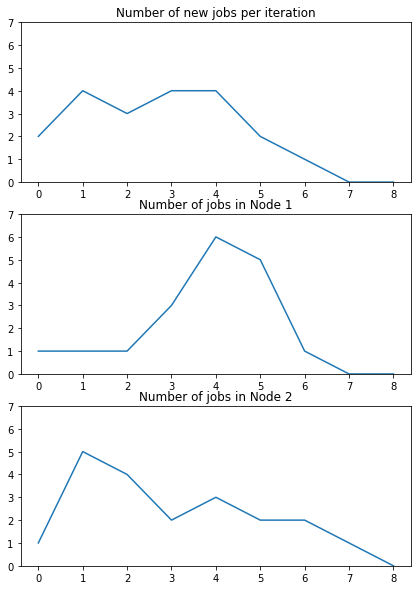

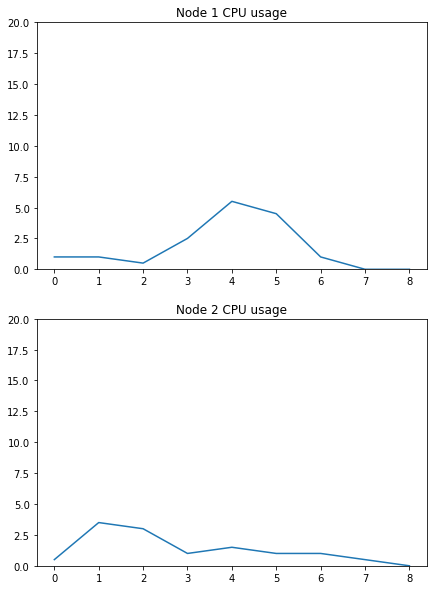

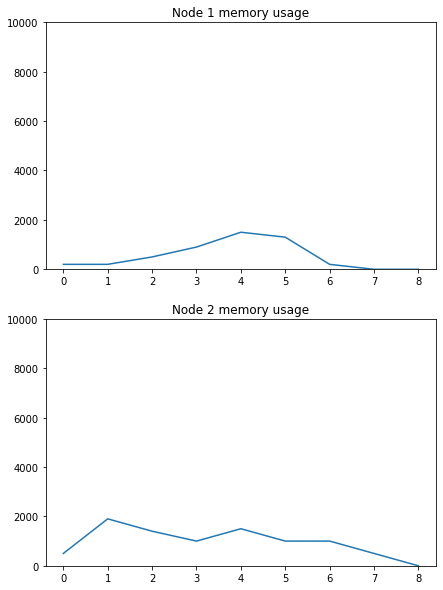

In [13]:
# Number of jobs
n_jobs = 20

# Characteristics job 1
cpu_job_1 = 1
memory_job_1 = 200
file_size_job_1 = 2

# Characteristics job 2
cpu_job_2 = 0.5
memory_job_2 = 500
file_size_job_2 = 4

# Append in lists the requirements of the jobs
cpu_jobs_reqs = [cpu_job_1, cpu_job_2]
memory_jobs_reqs = [memory_job_1, memory_job_2]
file_size_jobs_reqs = [file_size_job_1, file_size_job_2]

# Create a list to store the jobs
jobs_list = []

# We store 1 job in the list in each iteration randomly choosing between the two types of jobs
for i in range(n_jobs):
    job_type = random.randint(0, 1)
    cpu_job = cpu_jobs_reqs[job_type]
    memory_job = memory_jobs_reqs[job_type]
    file_size_job = file_size_jobs_reqs[job_type]
    jobs_list.append(Job(i, cpu_job, memory_job, file_size_job))
    
# Create the two nodes

# Characteristics node 1
cpu_node_1 = 20
memory_node_1 = 10000
bw_node_1 = 1

# Characteristics node 2
cpu_node_2 = 20
memory_node_2 = 10000
bw_node_2 = 2

nodes_cpu = [cpu_node_1, cpu_node_2]
nodes_memory = [memory_node_1, memory_node_2]
nodes_bw = [bw_node_1, bw_node_2]

main_simulation(2, nodes_cpu, nodes_memory, nodes_bw, jobs_list, 0)